In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM



Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


0     -0.025547
1      0.092241
2      0.091614
3     -0.029861
4     -0.081061
5     -0.081246
6      0.075370
7     -0.018363
8     -0.065202
9      0.064017
10     0.035250
11    -0.054299
12    -0.080261
13     0.032733
14     0.039559
15     0.112890
16     0.014132
17    -0.040457
18    -0.143370
19    -0.080158
20    -0.046180
21     0.160100
22     0.036908
23    -0.030857
24    -0.161610
25    -0.074868
26     0.005449
27     0.152760
28     0.140540
29    -0.030355
         ...   
726   -0.332560
727   -0.482560
728   -0.501440
729   -0.495780
730   -0.458700
731   -0.377350
732   -0.237240
733   -0.023669
734    0.178070
735    0.282680
736    0.304860
737    0.359330
738    0.255480
739    0.081523
740   -0.079644
741   -0.245120
742   -0.228700
743   -0.134050
744    0.025670
745    0.131620
746    0.071521
747   -0.037868
748   -0.069171
749    0.015659
750    0.046654
751   -0.041721
752   -0.004281
753    0.038246
754    0.042989
755    0.042706
Name: f0, Length: 756, d

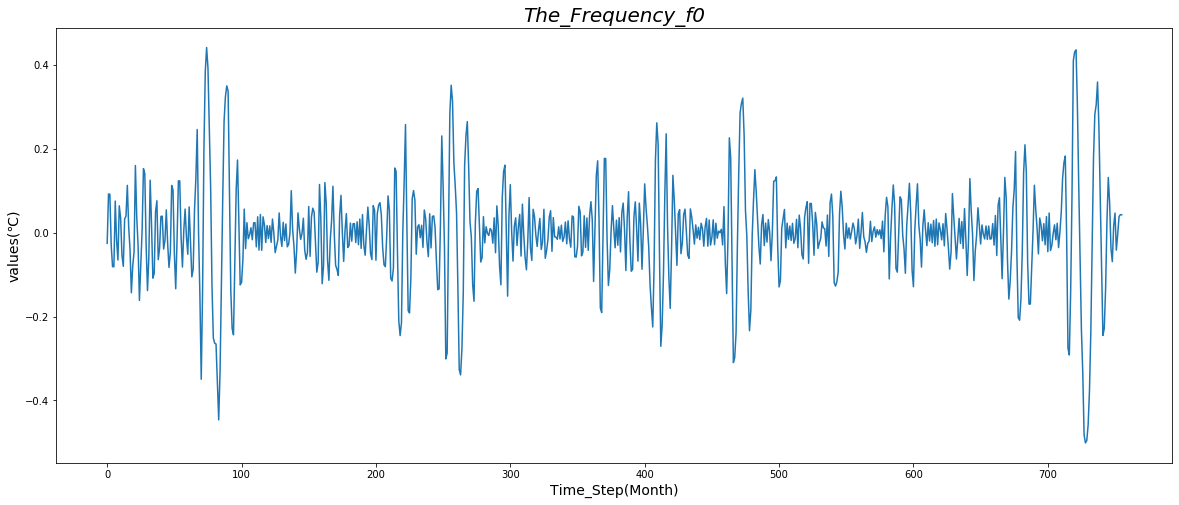

[[[-2.5547e-02]
  [ 9.2241e-02]
  [ 9.1614e-02]
  [-2.9861e-02]
  [-8.1061e-02]
  [-8.1246e-02]
  [ 7.5370e-02]
  [-1.8363e-02]
  [-6.5202e-02]
  [ 6.4017e-02]
  [ 3.5250e-02]
  [-5.4299e-02]]

 [[-8.0261e-02]
  [ 3.2733e-02]
  [ 3.9559e-02]
  [ 1.1289e-01]
  [ 1.4132e-02]
  [-4.0457e-02]
  [-1.4337e-01]
  [-8.0158e-02]
  [-4.6180e-02]
  [ 1.6010e-01]
  [ 3.6908e-02]
  [-3.0857e-02]]

 [[-1.6161e-01]
  [-7.4868e-02]
  [ 5.4492e-03]
  [ 1.5276e-01]
  [ 1.4054e-01]
  [-3.0355e-02]
  [-1.3808e-01]
  [-5.8738e-02]
  [ 1.2519e-01]
  [ 1.9747e-02]
  [-1.0855e-01]
  [-9.7296e-02]]

 [[ 4.9602e-02]
  [ 7.6171e-02]
  [-6.4388e-02]
  [-3.7326e-02]
  [ 3.8834e-02]
  [ 3.9240e-02]
  [-3.9069e-02]
  [-1.8257e-02]
  [ 5.4259e-02]
  [-2.5882e-02]
  [-8.3007e-02]
  [-4.7521e-02]]

 [[ 1.1258e-01]
  [ 1.0203e-01]
  [-5.0122e-02]
  [-1.3377e-01]
  [-1.6454e-02]
  [ 1.2364e-01]
  [ 1.2345e-01]
  [-1.0158e-02]
  [-8.2005e-02]
  [ 4.5278e-03]
  [ 5.6274e-02]
  [-1.0434e-02]]

 [[-5.1485e-02]
  [ 6.1355e-02

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 7s - loss: 0.0138
Epoch 2/200
 - 2s - loss: 0.0137
Epoch 3/200
 - 2s - loss: 0.0137
Epoch 4/200
 - 2s - loss: 0.0137
Epoch 5/200
 - 2s - loss: 0.0136
Epoch 6/200
 - 2s - loss: 0.0136
Epoch 7/200
 - 2s - loss: 0.0135
Epoch 8/200
 - 2s - loss: 0.0134
Epoch 9/200
 - 2s - loss: 0.0128
Epoch 10/200
 - 2s - loss: 0.0128
Epoch 11/200
 - 2s - loss: 0.0122
Epoch 12/200
 - 2s - loss: 0.0122
Epoch 13/200
 - 2s - loss: 0.0120
Epoch 14/200
 - 2s - loss: 0.0114
Epoch 15/200
 - 2s - loss: 0.0111
Epoch 16/200
 - 2s - loss: 0.0116
Epoch 17/200
 - 2s - loss: 0.0109
Epoch 18/200
 - 2s - loss: 0.0105
Epoch 19/200
 - 2s - loss: 0.0102
Epoch 20/200
 - 2s - loss: 0.0099
Epoch 21/200
 - 2s - loss: 0.0098
Epoch 22/200
 - 2s - loss: 0.0099
Epoch 23/200
 - 2s - loss: 0.0098
Epoch 24/200
 - 2s - loss: 0.0097
Epoch 25/200
 - 2s - loss: 0.0092
Epoch 26/200
 - 2s - loss: 0.0091
Epoch 27/200
 - 3s - loss: 0.0093
Epoch 28/200
 - 3s - loss: 0.0090
Epoch 29/

(60, 12)


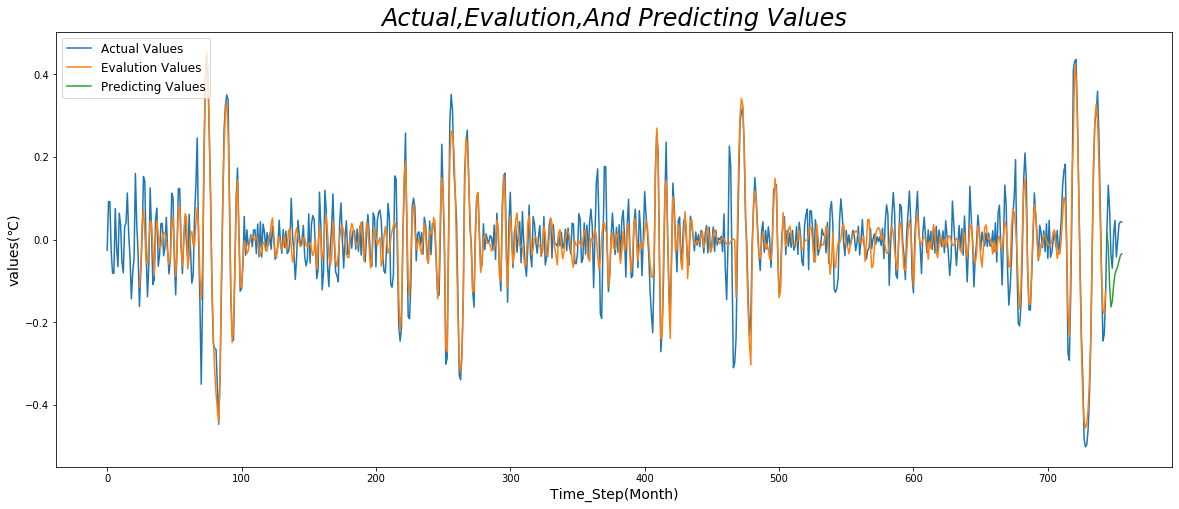

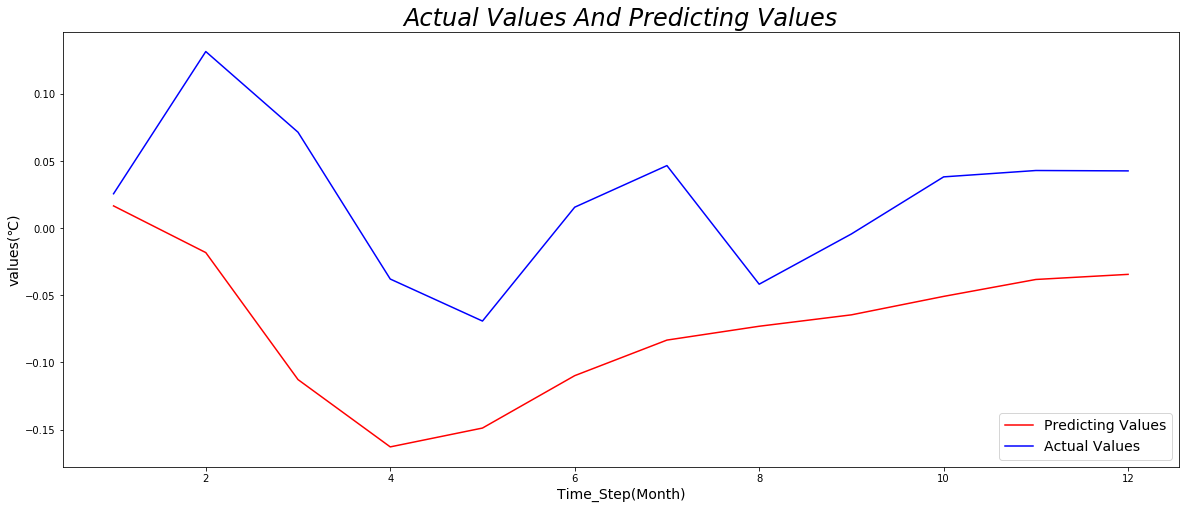

0     -0.294540
1     -0.206260
2     -0.114940
3     -0.018285
4      0.092434
5      0.236340
6      0.407510
7      0.512940
8      0.455400
9      0.206520
10    -0.097637
11    -0.351990
12    -0.478850
13    -0.451500
14    -0.319580
15    -0.149650
16     0.002985
17     0.128160
18     0.224470
19     0.283560
20     0.306910
21     0.296920
22     0.250800
23     0.176900
24     0.086898
25    -0.006406
26    -0.085830
27    -0.131520
28    -0.123820
29    -0.071080
         ...   
726   -0.416050
727   -0.506440
728   -0.532560
729   -0.492060
730   -0.395240
731   -0.257820
732   -0.096603
733    0.071551
734    0.229770
735    0.361170
736    0.448900
737    0.476080
738    0.431720
739    0.329120
740    0.190310
741    0.038030
742   -0.108260
743   -0.239260
744   -0.336230
745   -0.374840
746   -0.337770
747   -0.237250
748   -0.096246
749    0.051585
750    0.180610
751    0.260780
752    0.248830
753    0.157580
754    0.019498
755   -0.108560
Name: f1, Length: 756, d

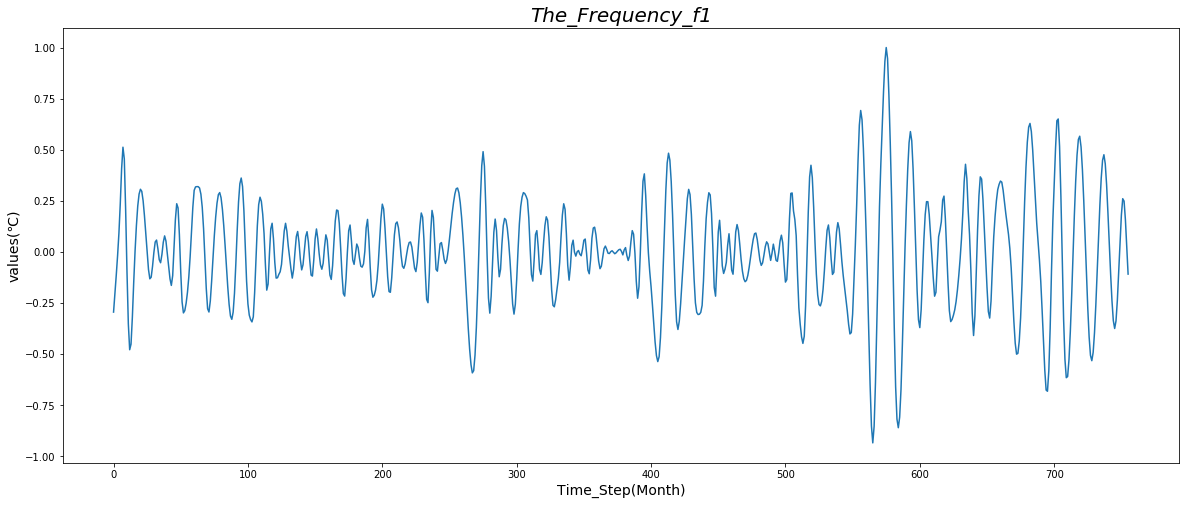

[[[-2.9454e-01]
  [-2.0626e-01]
  [-1.1494e-01]
  [-1.8285e-02]
  [ 9.2434e-02]
  [ 2.3634e-01]
  [ 4.0751e-01]
  [ 5.1294e-01]
  [ 4.5540e-01]
  [ 2.0652e-01]
  [-9.7637e-02]
  [-3.5199e-01]]

 [[-4.7885e-01]
  [-4.5150e-01]
  [-3.1958e-01]
  [-1.4965e-01]
  [ 2.9850e-03]
  [ 1.2816e-01]
  [ 2.2447e-01]
  [ 2.8356e-01]
  [ 3.0691e-01]
  [ 2.9692e-01]
  [ 2.5080e-01]
  [ 1.7690e-01]]

 [[ 8.6898e-02]
  [-6.4059e-03]
  [-8.5830e-02]
  [-1.3152e-01]
  [-1.2382e-01]
  [-7.1080e-02]
  [-3.0445e-03]
  [ 4.8778e-02]
  [ 5.8154e-02]
  [ 1.5810e-02]
  [-3.7963e-02]
  [-5.2927e-02]]

 [[-1.2426e-02]
  [ 4.7069e-02]
  [ 7.8590e-02]
  [ 5.3272e-02]
  [-5.8918e-03]
  [-6.9886e-02]
  [-1.3140e-01]
  [-1.6388e-01]
  [-1.1630e-01]
  [ 1.6081e-02]
  [ 1.5718e-01]
  [ 2.3609e-01]]

 [[ 2.1549e-01]
  [ 8.3197e-02]
  [-9.7596e-02]
  [-2.4477e-01]
  [-2.9853e-01]
  [-2.8754e-01]
  [-2.5153e-01]
  [-1.9811e-01]
  [-1.2294e-01]
  [-2.2837e-02]
  [ 9.6141e-02]
  [ 2.1869e-01]]

 [[ 3.0174e-01]
  [ 3.1849e-01

Epoch 1/200
 - 7s - loss: 0.0667
Epoch 2/200
 - 3s - loss: 0.0606
Epoch 3/200
 - 2s - loss: 0.0514
Epoch 4/200
 - 2s - loss: 0.0449
Epoch 5/200
 - 2s - loss: 0.0422
Epoch 6/200
 - 2s - loss: 0.0393
Epoch 7/200
 - 2s - loss: 0.0383
Epoch 8/200
 - 2s - loss: 0.0359
Epoch 9/200
 - 2s - loss: 0.0337
Epoch 10/200
 - 2s - loss: 0.0324
Epoch 11/200
 - 2s - loss: 0.0305
Epoch 12/200
 - 2s - loss: 0.0315
Epoch 13/200
 - 2s - loss: 0.0309
Epoch 14/200
 - 2s - loss: 0.0283
Epoch 15/200
 - 2s - loss: 0.0312
Epoch 16/200
 - 2s - loss: 0.0295
Epoch 17/200
 - 2s - loss: 0.0287
Epoch 18/200
 - 2s - loss: 0.0263
Epoch 19/200
 - 2s - loss: 0.0262
Epoch 20/200
 - 2s - loss: 0.0277
Epoch 21/200
 - 2s - loss: 0.0264
Epoch 22/200
 - 2s - loss: 0.0249
Epoch 23/200
 - 2s - loss: 0.0277
Epoch 24/200
 - 2s - loss: 0.0259
Epoch 25/200
 - 2s - loss: 0.0248
Epoch 26/200
 - 2s - loss: 0.0244
Epoch 27/200
 - 2s - loss: 0.0250
Epoch 28/200
 - 2s - loss: 0.0251
Epoch 29/200
 - 2s - loss: 0.0232
Epoch 30/200
 - 2s - lo

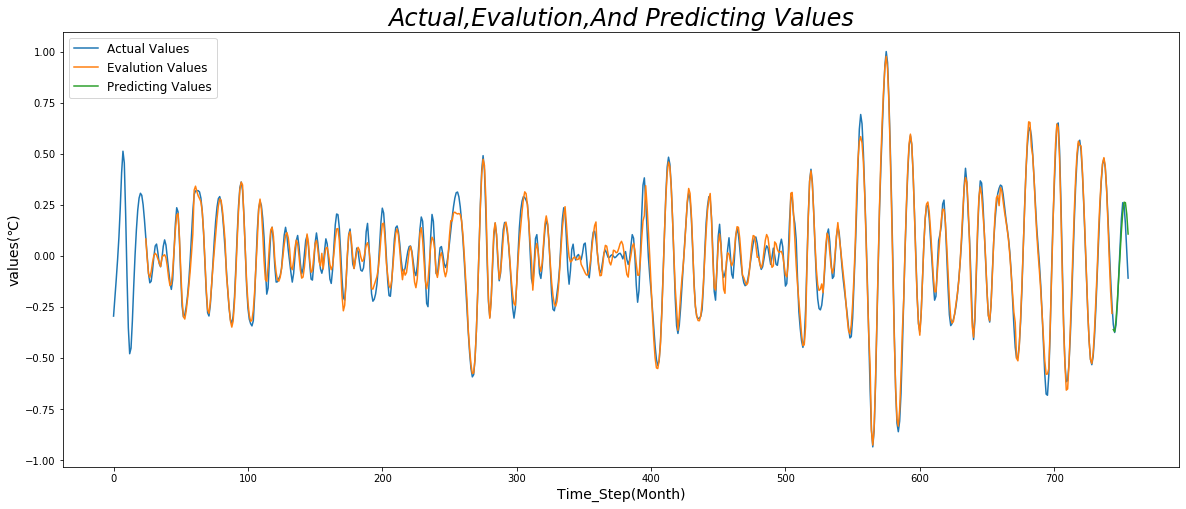

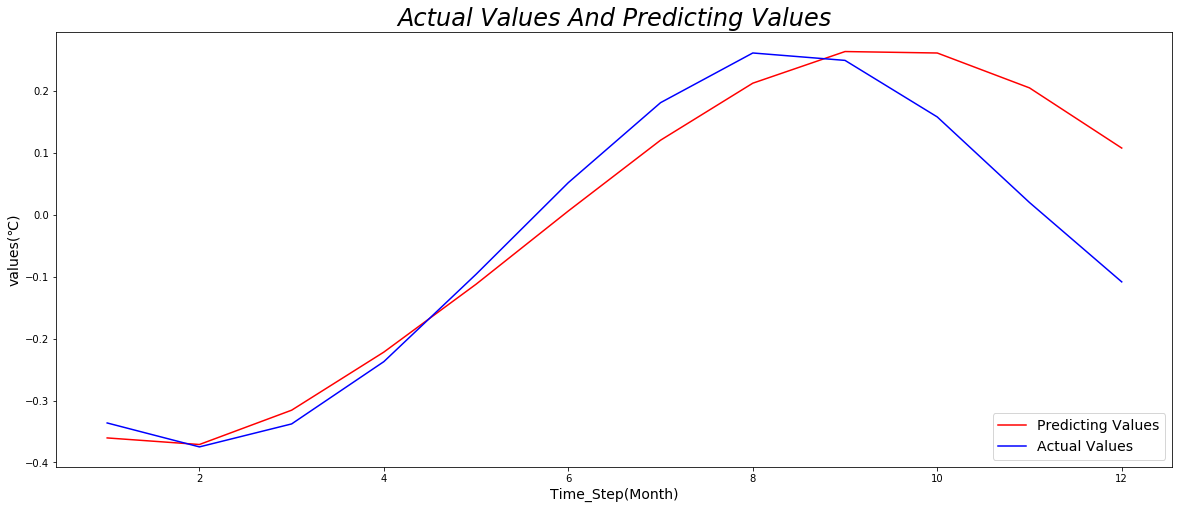

0     -0.438890
1     -0.456720
2     -0.466010
3     -0.466450
4     -0.457420
5     -0.438230
6     -0.408210
7     -0.366670
8     -0.313070
9     -0.247670
10    -0.171950
11    -0.087650
12     0.003699
13     0.100570
14     0.198250
15     0.291170
16     0.373790
17     0.440530
18     0.485840
19     0.504150
20     0.489910
21     0.439690
22     0.358500
23     0.253460
24     0.131690
25     0.000284
26    -0.133640
27    -0.262960
28    -0.380460
29    -0.478240
         ...   
726    0.262660
727    0.136790
728    0.013370
729   -0.104050
730   -0.212760
731   -0.310570
732   -0.395880
733   -0.467230
734   -0.523130
735   -0.562130
736   -0.582750
737   -0.583310
738   -0.561790
739   -0.518520
740   -0.457210
741   -0.382230
742   -0.297980
743   -0.208850
744   -0.119160
745   -0.033139
746    0.045401
747    0.113200
748    0.167120
749    0.204010
750    0.220720
751    0.214080
752    0.182920
753    0.134410
754    0.077831
755    0.022456
Name: f2, Length: 756, d

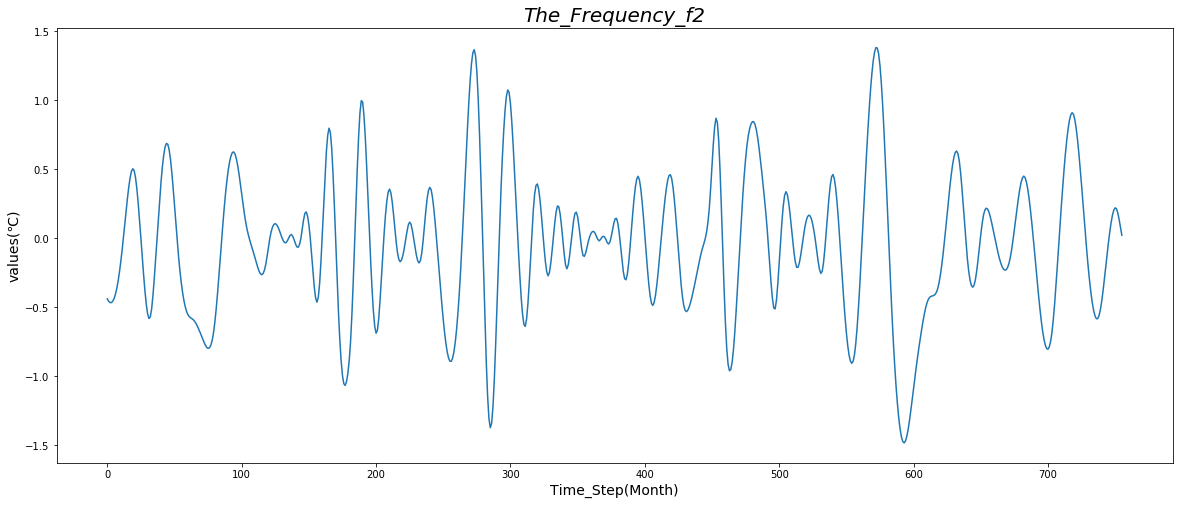

[[[-4.3889e-01]
  [-4.5672e-01]
  [-4.6601e-01]
  [-4.6645e-01]
  [-4.5742e-01]
  [-4.3823e-01]
  [-4.0821e-01]
  [-3.6667e-01]
  [-3.1307e-01]
  [-2.4767e-01]
  [-1.7195e-01]
  [-8.7650e-02]]

 [[ 3.6991e-03]
  [ 1.0057e-01]
  [ 1.9825e-01]
  [ 2.9117e-01]
  [ 3.7379e-01]
  [ 4.4053e-01]
  [ 4.8584e-01]
  [ 5.0415e-01]
  [ 4.8991e-01]
  [ 4.3969e-01]
  [ 3.5850e-01]
  [ 2.5346e-01]]

 [[ 1.3169e-01]
  [ 2.8436e-04]
  [-1.3364e-01]
  [-2.6296e-01]
  [-3.8046e-01]
  [-4.7824e-01]
  [-5.4803e-01]
  [-5.8184e-01]
  [-5.7069e-01]
  [-5.1160e-01]
  [-4.1193e-01]
  [-2.8498e-01]]

 [[-1.4410e-01]
  [ 2.5337e-03]
  [ 1.4806e-01]
  [ 2.8598e-01]
  [ 4.1120e-01]
  [ 5.1893e-01]
  [ 6.0420e-01]
  [ 6.6199e-01]
  [ 6.8813e-01]
  [ 6.8186e-01]
  [ 6.4337e-01]
  [ 5.7378e-01]]

 [[ 4.7821e-01]
  [ 3.6393e-01]
  [ 2.3850e-01]
  [ 1.0950e-01]
  [-1.5500e-02]
  [-1.2986e-01]
  [-2.3097e-01]
  [-3.1827e-01]
  [-3.9149e-01]
  [-4.5060e-01]
  [-4.9659e-01]
  [-5.3066e-01]]

 [[-5.5404e-01]
  [-5.6837e-01

Epoch 1/200
 - 9s - loss: 0.2556
Epoch 2/200
 - 2s - loss: 0.2342
Epoch 3/200
 - 2s - loss: 0.2184
Epoch 4/200
 - 2s - loss: 0.1766
Epoch 5/200
 - 3s - loss: 0.1476
Epoch 6/200
 - 2s - loss: 0.1260
Epoch 7/200
 - 2s - loss: 0.1187
Epoch 8/200
 - 2s - loss: 0.0982
Epoch 9/200
 - 2s - loss: 0.0949
Epoch 10/200
 - 2s - loss: 0.0964
Epoch 11/200
 - 2s - loss: 0.0940
Epoch 12/200
 - 2s - loss: 0.0789
Epoch 13/200
 - 2s - loss: 0.0755
Epoch 14/200
 - 2s - loss: 0.0747
Epoch 15/200
 - 2s - loss: 0.0830
Epoch 16/200
 - 2s - loss: 0.0724
Epoch 17/200
 - 2s - loss: 0.0645
Epoch 18/200
 - 2s - loss: 0.0978
Epoch 19/200
 - 2s - loss: 0.0659
Epoch 20/200
 - 2s - loss: 0.0737
Epoch 21/200
 - 2s - loss: 0.0614
Epoch 22/200
 - 2s - loss: 0.0599
Epoch 23/200
 - 2s - loss: 0.0539
Epoch 24/200
 - 2s - loss: 0.0665
Epoch 25/200
 - 3s - loss: 0.0536
Epoch 26/200
 - 2s - loss: 0.0520
Epoch 27/200
 - 2s - loss: 0.0560
Epoch 28/200
 - 2s - loss: 0.0527
Epoch 29/200
 - 2s - loss: 0.0464
Epoch 30/200
 - 2s - lo

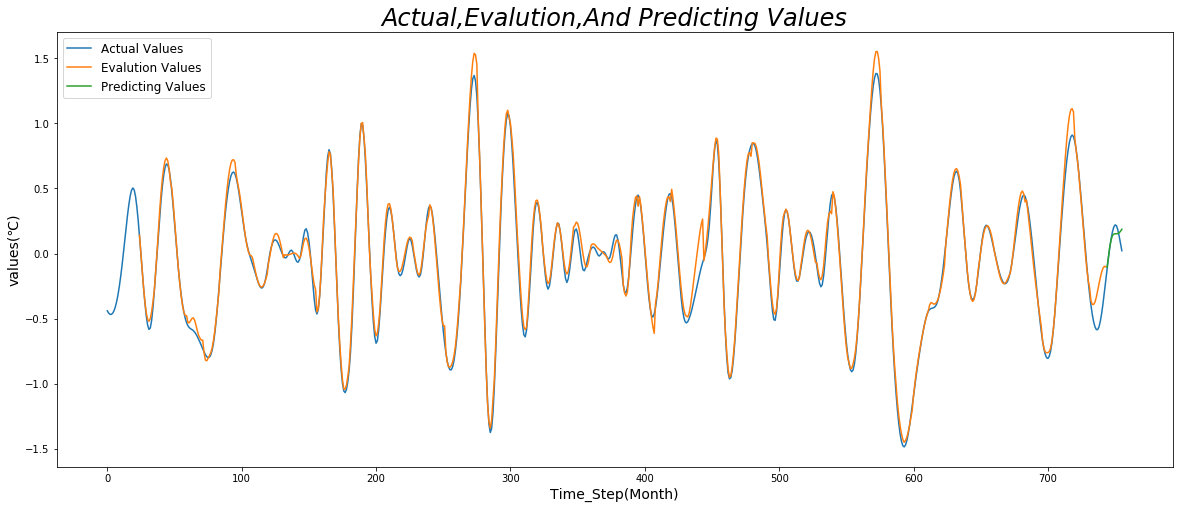

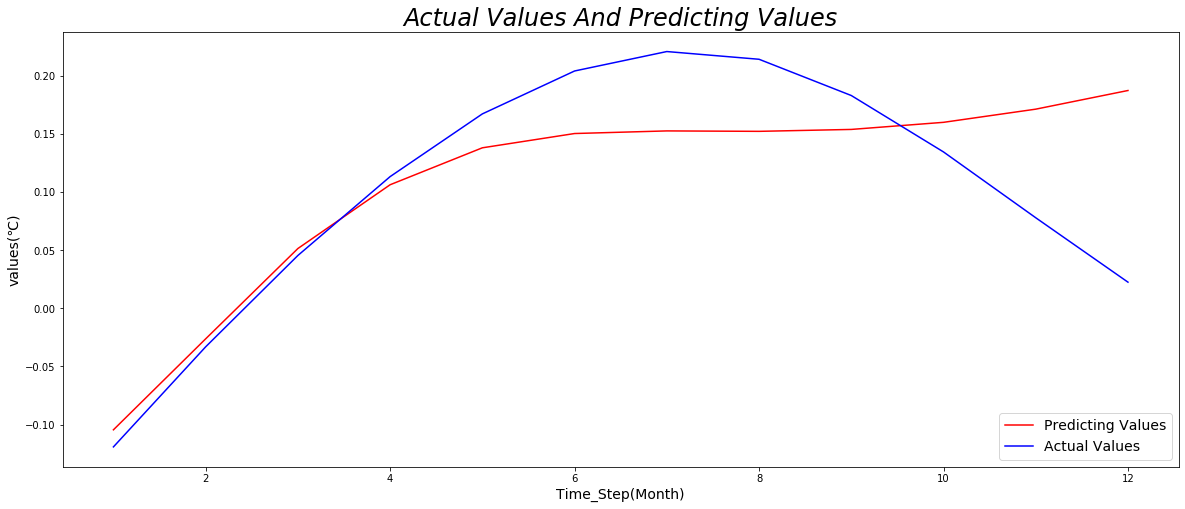

0     -0.538450
1     -0.526230
2     -0.507350
3     -0.481980
4     -0.450610
5     -0.413780
6     -0.372030
7     -0.325890
8     -0.275900
9     -0.222610
10    -0.166550
11    -0.108270
12    -0.048294
13     0.012829
14     0.074562
15     0.136370
16     0.197700
17     0.258030
18     0.316810
19     0.373510
20     0.427580
21     0.478490
22     0.525830
23     0.569200
24     0.608230
25     0.642540
26     0.671750
27     0.695490
28     0.713370
29     0.725020
         ...   
726   -0.019950
727   -0.046766
728   -0.072172
729   -0.095532
730   -0.116210
731   -0.133570
732   -0.146980
733   -0.155810
734   -0.159410
735   -0.157140
736   -0.148340
737   -0.132530
738   -0.110200
739   -0.082479
740   -0.050654
741   -0.015994
742    0.020232
743    0.056753
744    0.092297
745    0.125590
746    0.155370
747    0.180360
748    0.199290
749    0.210890
750    0.213890
751    0.207050
752    0.189680
753    0.162600
754    0.127040
755    0.084259
Name: f3, Length: 756, d

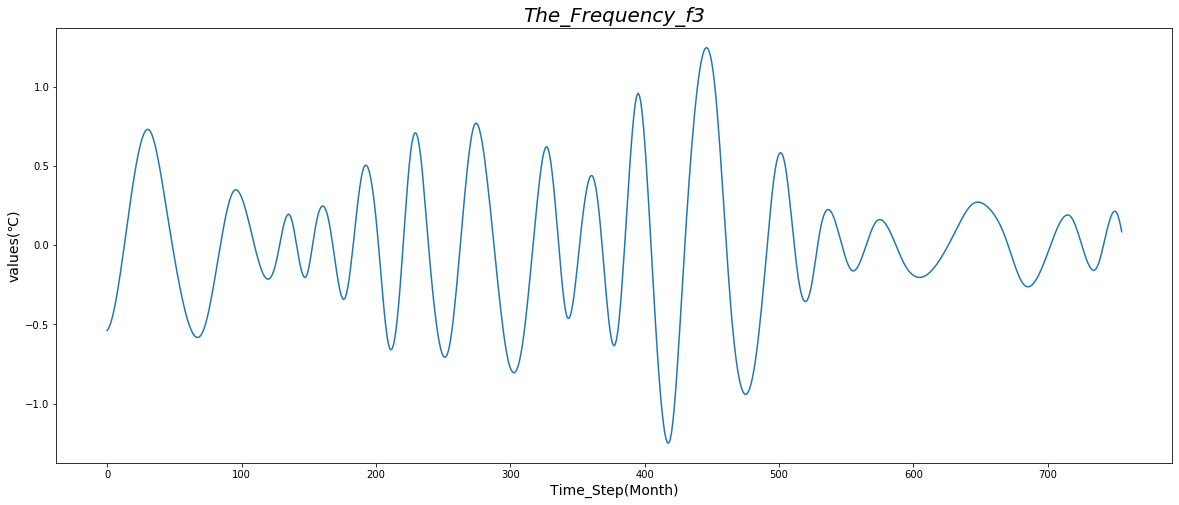

[[[-5.3845e-01]
  [-5.2623e-01]
  [-5.0735e-01]
  [-4.8198e-01]
  [-4.5061e-01]
  [-4.1378e-01]
  [-3.7203e-01]
  [-3.2589e-01]
  [-2.7590e-01]
  [-2.2261e-01]
  [-1.6655e-01]
  [-1.0827e-01]]

 [[-4.8294e-02]
  [ 1.2829e-02]
  [ 7.4562e-02]
  [ 1.3637e-01]
  [ 1.9770e-01]
  [ 2.5803e-01]
  [ 3.1681e-01]
  [ 3.7351e-01]
  [ 4.2758e-01]
  [ 4.7849e-01]
  [ 5.2583e-01]
  [ 5.6920e-01]]

 [[ 6.0823e-01]
  [ 6.4254e-01]
  [ 6.7175e-01]
  [ 6.9549e-01]
  [ 7.1337e-01]
  [ 7.2502e-01]
  [ 7.3005e-01]
  [ 7.2810e-01]
  [ 7.1888e-01]
  [ 7.0263e-01]
  [ 6.7994e-01]
  [ 6.5140e-01]]

 [[ 6.1765e-01]
  [ 5.7930e-01]
  [ 5.3698e-01]
  [ 4.9129e-01]
  [ 4.4287e-01]
  [ 3.9232e-01]
  [ 3.4028e-01]
  [ 2.8736e-01]
  [ 2.3413e-01]
  [ 1.8096e-01]
  [ 1.2808e-01]
  [ 7.5673e-02]]

 [[ 2.3922e-02]
  [-2.6981e-02]
  [-7.6848e-02]
  [-1.2549e-01]
  [-1.7272e-01]
  [-2.1835e-01]
  [-2.6219e-01]
  [-3.0405e-01]
  [-3.4374e-01]
  [-3.8107e-01]
  [-4.1587e-01]
  [-4.4793e-01]]

 [[-4.7707e-01]
  [-5.0310e-01

Epoch 1/200
 - 9s - loss: 0.1504
Epoch 2/200
 - 3s - loss: 0.1337
Epoch 3/200
 - 2s - loss: 0.0837
Epoch 4/200
 - 2s - loss: 0.0622
Epoch 5/200
 - 2s - loss: 0.0513
Epoch 6/200
 - 2s - loss: 0.0472
Epoch 7/200
 - 2s - loss: 0.0366
Epoch 8/200
 - 2s - loss: 0.0431
Epoch 9/200
 - 2s - loss: 0.0396
Epoch 10/200
 - 2s - loss: 0.0263
Epoch 11/200
 - 2s - loss: 0.0222
Epoch 12/200
 - 2s - loss: 0.0223
Epoch 13/200
 - 2s - loss: 0.0202
Epoch 14/200
 - 2s - loss: 0.0150
Epoch 15/200
 - 2s - loss: 0.0220
Epoch 16/200
 - 2s - loss: 0.0154
Epoch 17/200
 - 2s - loss: 0.0121
Epoch 18/200
 - 2s - loss: 0.0115
Epoch 19/200
 - 2s - loss: 0.0140
Epoch 20/200
 - 2s - loss: 0.0120
Epoch 21/200
 - 2s - loss: 0.0127
Epoch 22/200
 - 2s - loss: 0.0135
Epoch 23/200
 - 2s - loss: 0.0134
Epoch 24/200
 - 2s - loss: 0.0092
Epoch 25/200
 - 2s - loss: 0.0092
Epoch 26/200
 - 2s - loss: 0.0094
Epoch 27/200
 - 2s - loss: 0.0137
Epoch 28/200
 - 2s - loss: 0.0091
Epoch 29/200
 - 2s - loss: 0.0084
Epoch 30/200
 - 2s - lo

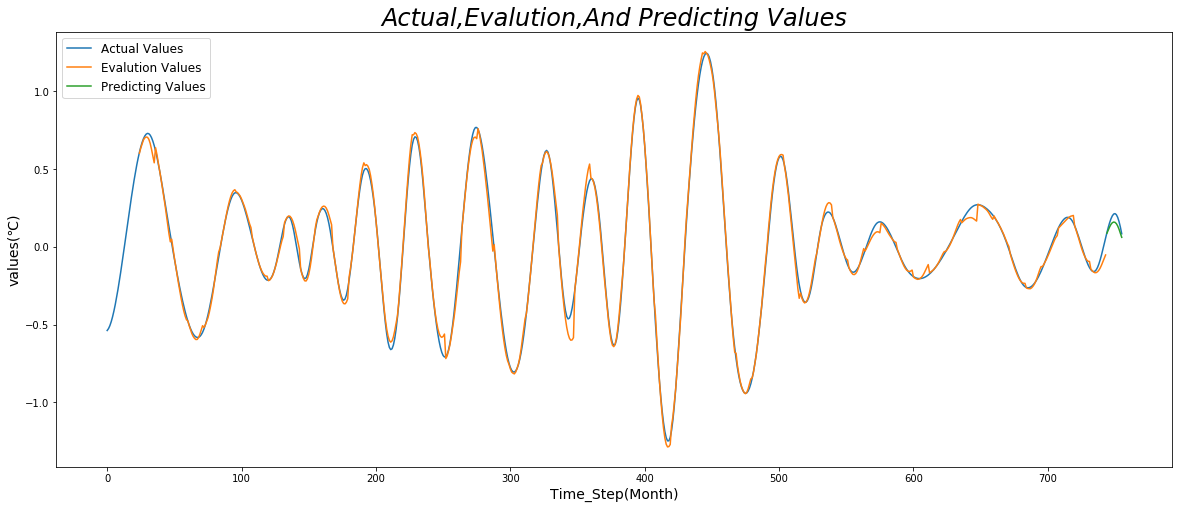

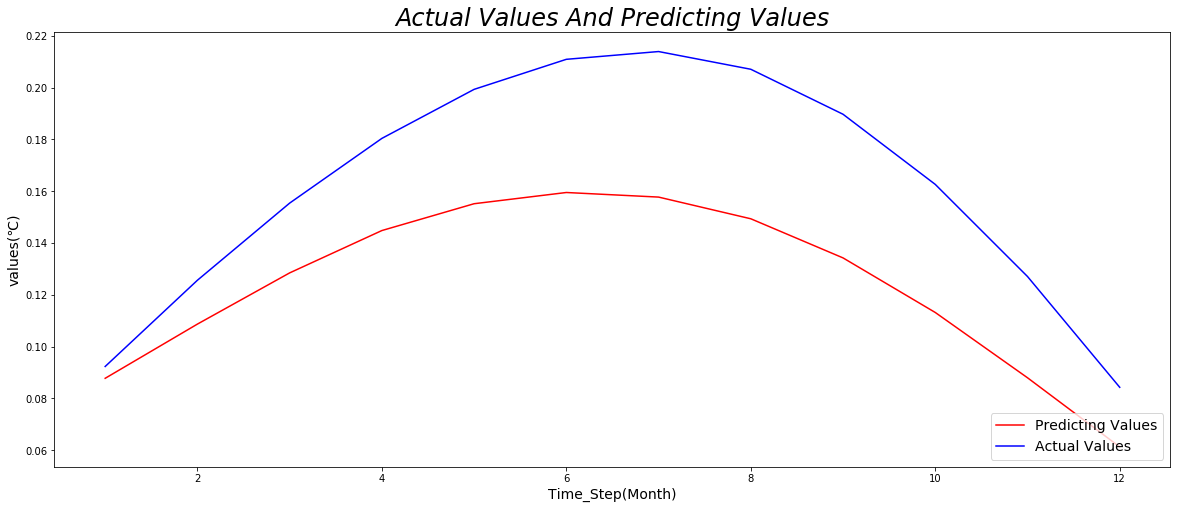

0     -0.21581
1     -0.21438
2     -0.21291
3     -0.21139
4     -0.20982
5     -0.20820
6     -0.20653
7     -0.20481
8     -0.20303
9     -0.20120
10    -0.19931
11    -0.19736
12    -0.19536
13    -0.19329
14    -0.19116
15    -0.18896
16    -0.18670
17    -0.18438
18    -0.18198
19    -0.17952
20    -0.17699
21    -0.17439
22    -0.17171
23    -0.16896
24    -0.16613
25    -0.16323
26    -0.16025
27    -0.15719
28    -0.15405
29    -0.15082
        ...   
726   -0.35086
727   -0.36210
728   -0.37264
729   -0.38244
730   -0.39143
731   -0.39954
732   -0.40672
733   -0.41290
734   -0.41802
735   -0.42202
736   -0.42487
737   -0.42656
738   -0.42706
739   -0.42635
740   -0.42443
741   -0.42126
742   -0.41683
743   -0.41112
744   -0.40412
745   -0.39579
746   -0.38613
747   -0.37512
748   -0.36273
749   -0.34896
750   -0.33377
751   -0.31716
752   -0.29920
753   -0.27995
754   -0.25955
755   -0.23810
Name: f4, Length: 756, dtype: float64
(756,)


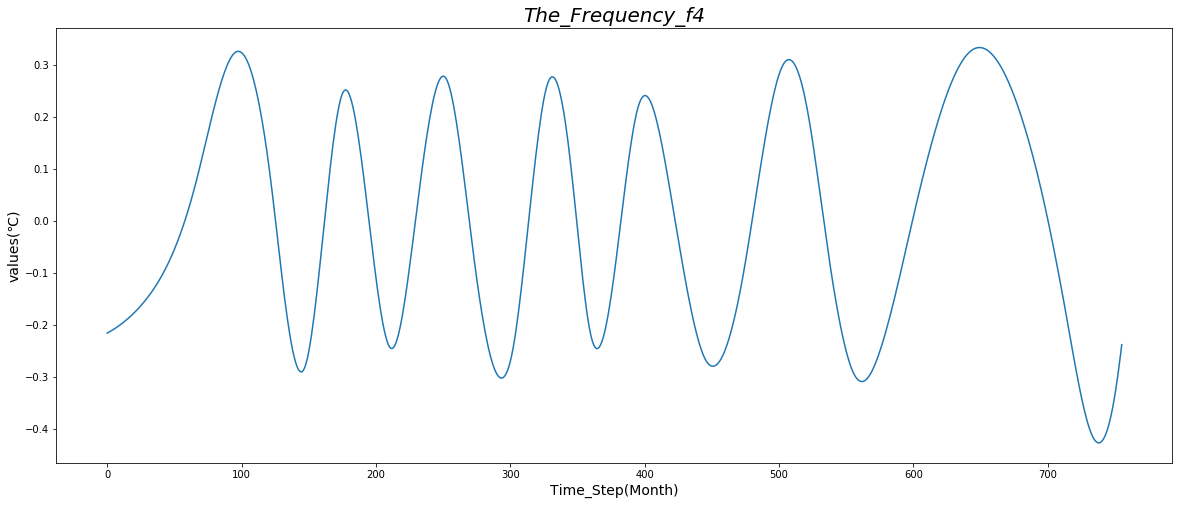

[[[-0.21581  ]
  [-0.21438  ]
  [-0.21291  ]
  [-0.21139  ]
  [-0.20982  ]
  [-0.2082   ]
  [-0.20653  ]
  [-0.20481  ]
  [-0.20303  ]
  [-0.2012   ]
  [-0.19931  ]
  [-0.19736  ]]

 [[-0.19536  ]
  [-0.19329  ]
  [-0.19116  ]
  [-0.18896  ]
  [-0.1867   ]
  [-0.18438  ]
  [-0.18198  ]
  [-0.17952  ]
  [-0.17699  ]
  [-0.17439  ]
  [-0.17171  ]
  [-0.16896  ]]

 [[-0.16613  ]
  [-0.16323  ]
  [-0.16025  ]
  [-0.15719  ]
  [-0.15405  ]
  [-0.15082  ]
  [-0.14752  ]
  [-0.14412  ]
  [-0.14063  ]
  [-0.13703  ]
  [-0.13331  ]
  [-0.12948  ]]

 [[-0.12553  ]
  [-0.12146  ]
  [-0.11725  ]
  [-0.11291  ]
  [-0.10842  ]
  [-0.10379  ]
  [-0.099013 ]
  [-0.094078 ]
  [-0.088983 ]
  [-0.083723 ]
  [-0.078293 ]
  [-0.072689 ]]

 [[-0.066905 ]
  [-0.060937 ]
  [-0.054779 ]
  [-0.048428 ]
  [-0.041877 ]
  [-0.035123 ]
  [-0.028161 ]
  [-0.020985 ]
  [-0.01359  ]
  [-0.0059729]
  [ 0.0018726]
  [ 0.0099509]]

 [[ 0.018267 ]
  [ 0.026826 ]
  [ 0.035632 ]
  [ 0.04469  ]
  [ 0.054005 ]
  [ 0.06358  ]


Epoch 1/200
 - 8s - loss: 0.0324
Epoch 2/200
 - 2s - loss: 0.0102
Epoch 3/200
 - 5s - loss: 0.0051
Epoch 4/200
 - 3s - loss: 0.0047
Epoch 5/200
 - 4s - loss: 0.0024
Epoch 6/200
 - 3s - loss: 0.0019
Epoch 7/200
 - 3s - loss: 0.0014
Epoch 8/200
 - 3s - loss: 0.0018
Epoch 9/200
 - 4s - loss: 9.4527e-04
Epoch 10/200
 - 2s - loss: 8.9760e-04
Epoch 11/200
 - 2s - loss: 8.4963e-04
Epoch 12/200
 - 2s - loss: 8.0475e-04
Epoch 13/200
 - 2s - loss: 8.7774e-04
Epoch 14/200
 - 2s - loss: 0.0017
Epoch 15/200
 - 2s - loss: 9.7252e-04
Epoch 16/200
 - 2s - loss: 8.9318e-04
Epoch 17/200
 - 2s - loss: 0.0011
Epoch 18/200
 - 2s - loss: 6.6840e-04
Epoch 19/200
 - 2s - loss: 9.7013e-04
Epoch 20/200
 - 2s - loss: 0.0018
Epoch 21/200
 - 2s - loss: 8.3309e-04
Epoch 22/200
 - 2s - loss: 5.8793e-04
Epoch 23/200
 - 2s - loss: 8.1744e-04
Epoch 24/200
 - 2s - loss: 7.8414e-04
Epoch 25/200
 - 2s - loss: 5.5682e-04
Epoch 26/200
 - 2s - loss: 6.3182e-04
Epoch 27/200
 - 2s - loss: 6.3010e-04
Epoch 28/200
 - 2s - loss: 

(60, 12)


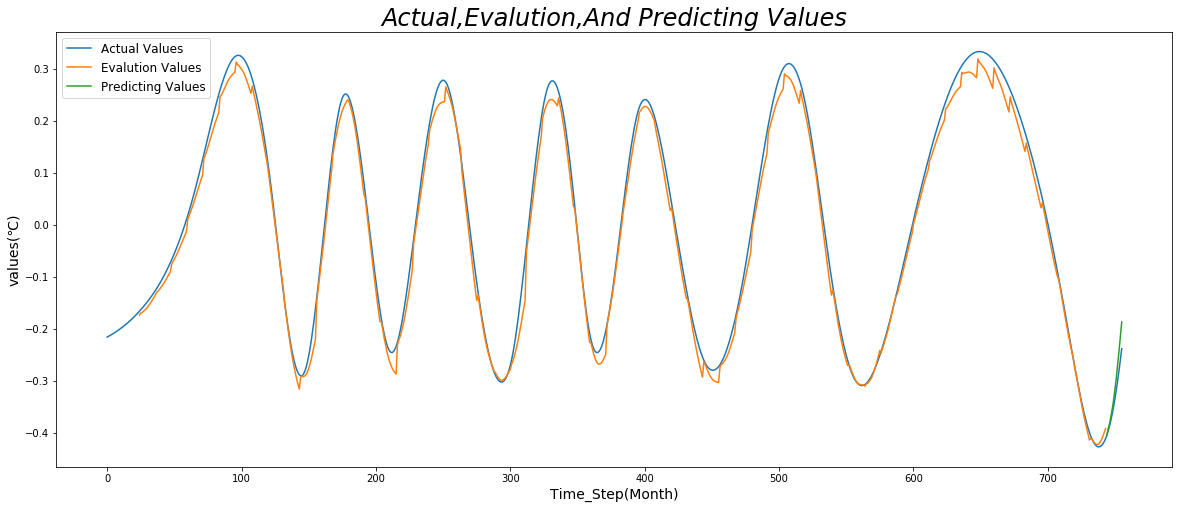

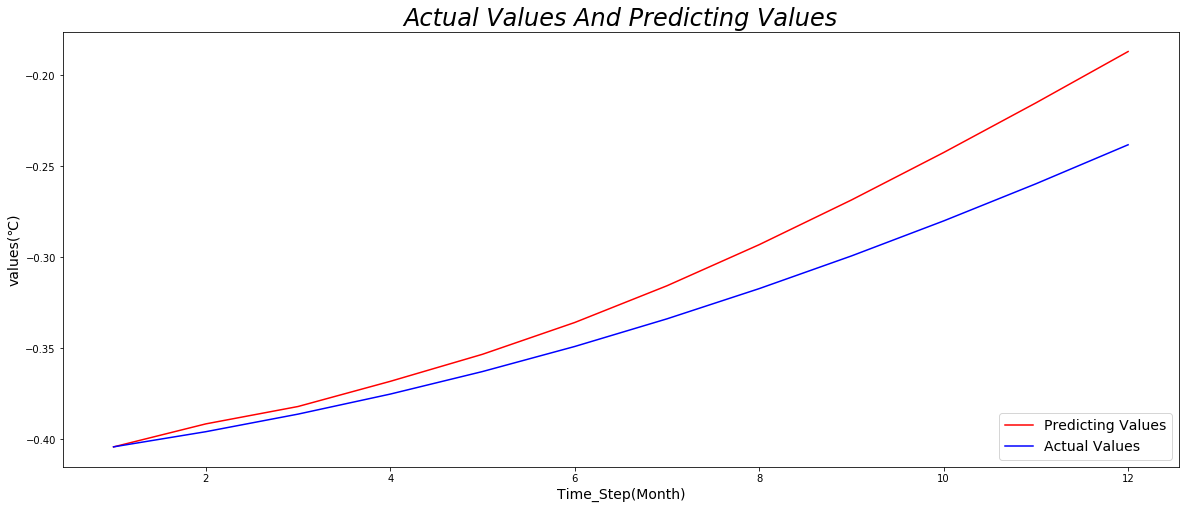

0      0.004482
1      0.003265
2      0.002159
3      0.001161
4      0.000266
5     -0.000529
6     -0.001226
7     -0.001830
8     -0.002343
9     -0.002768
10    -0.003109
11    -0.003368
12    -0.003548
13    -0.003654
14    -0.003686
15    -0.003650
16    -0.003548
17    -0.003384
18    -0.003162
19    -0.002884
20    -0.002554
21    -0.002177
22    -0.001754
23    -0.001289
24    -0.000785
25    -0.000244
26     0.000330
27     0.000934
28     0.001566
29     0.002224
         ...   
726   -0.076044
727   -0.072789
728   -0.069490
729   -0.066149
730   -0.062766
731   -0.059341
732   -0.055875
733   -0.052370
734   -0.048826
735   -0.045243
736   -0.041624
737   -0.037971
738   -0.034286
739   -0.030572
740   -0.026831
741   -0.023065
742   -0.019278
743   -0.015472
744   -0.011649
745   -0.007813
746   -0.003965
747   -0.000109
748    0.003754
749    0.007620
750    0.011488
751    0.015353
752    0.019215
753    0.023069
754    0.026914
755    0.030748
Name: f5, Length: 756, d

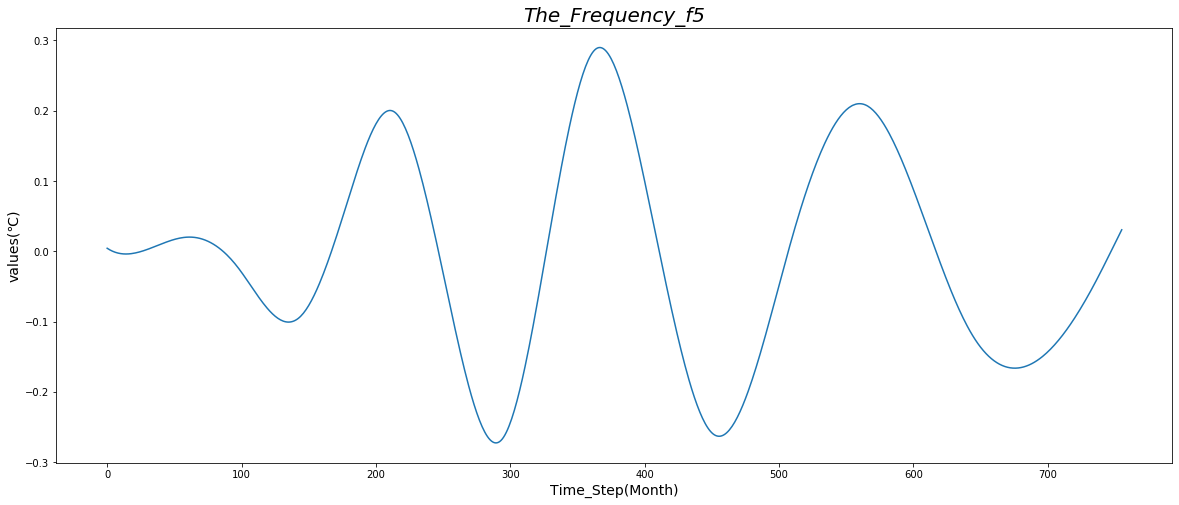

[[[ 4.4815e-03]
  [ 3.2649e-03]
  [ 2.1594e-03]
  [ 1.1610e-03]
  [ 2.6607e-04]
  [-5.2874e-04]
  [-1.2265e-03]
  [-1.8303e-03]
  [-2.3432e-03]
  [-2.7684e-03]
  [-3.1089e-03]
  [-3.3678e-03]]

 [[-3.5483e-03]
  [-3.6535e-03]
  [-3.6864e-03]
  [-3.6501e-03]
  [-3.5482e-03]
  [-3.3842e-03]
  [-3.1616e-03]
  [-2.8838e-03]
  [-2.5544e-03]
  [-2.1766e-03]
  [-1.7537e-03]
  [-1.2888e-03]]

 [[-7.8468e-04]
  [-2.4422e-04]
  [ 3.2968e-04]
  [ 9.3417e-04]
  [ 1.5665e-03]
  [ 2.2240e-03]
  [ 2.9039e-03]
  [ 3.6035e-03]
  [ 4.3202e-03]
  [ 5.0511e-03]
  [ 5.7937e-03]
  [ 6.5452e-03]]

 [[ 7.3028e-03]
  [ 8.0640e-03]
  [ 8.8259e-03]
  [ 9.5859e-03]
  [ 1.0341e-02]
  [ 1.1089e-02]
  [ 1.1827e-02]
  [ 1.2552e-02]
  [ 1.3262e-02]
  [ 1.3954e-02]
  [ 1.4624e-02]
  [ 1.5271e-02]]

 [[ 1.5892e-02]
  [ 1.6484e-02]
  [ 1.7044e-02]
  [ 1.7570e-02]
  [ 1.8058e-02]
  [ 1.8507e-02]
  [ 1.8913e-02]
  [ 1.9274e-02]
  [ 1.9587e-02]
  [ 1.9850e-02]
  [ 2.0061e-02]
  [ 2.0217e-02]]

 [[ 2.0317e-02]
  [ 2.0360e-02

Epoch 1/200
 - 19s - loss: 0.0128
Epoch 2/200
 - 4s - loss: 0.0063
Epoch 3/200
 - 4s - loss: 0.0015
Epoch 4/200
 - 4s - loss: 6.0963e-04
Epoch 5/200
 - 4s - loss: 2.3070e-04
Epoch 6/200
 - 4s - loss: 2.3700e-04
Epoch 7/200
 - 4s - loss: 1.5750e-04
Epoch 8/200
 - 4s - loss: 1.2025e-04
Epoch 9/200
 - 3s - loss: 9.0986e-05
Epoch 10/200
 - 3s - loss: 9.5000e-05
Epoch 11/200
 - 3s - loss: 1.0618e-04
Epoch 12/200
 - 3s - loss: 8.3306e-05
Epoch 13/200
 - 4s - loss: 8.2150e-05
Epoch 14/200
 - 4s - loss: 7.7947e-05
Epoch 15/200
 - 3s - loss: 2.0945e-04
Epoch 16/200
 - 3s - loss: 1.2236e-04
Epoch 17/200
 - 4s - loss: 8.5526e-05
Epoch 18/200
 - 4s - loss: 8.0358e-05
Epoch 19/200
 - 3s - loss: 6.5768e-05
Epoch 20/200
 - 3s - loss: 4.6684e-05
Epoch 21/200
 - 4s - loss: 6.3719e-05
Epoch 22/200
 - 4s - loss: 1.0402e-04
Epoch 23/200
 - 4s - loss: 4.1982e-04
Epoch 24/200
 - 3s - loss: 3.0674e-04
Epoch 25/200
 - 3s - loss: 8.1499e-05
Epoch 26/200
 - 3s - loss: 5.5900e-05
Epoch 27/200
 - 3s - loss: 5.440

(60, 12)


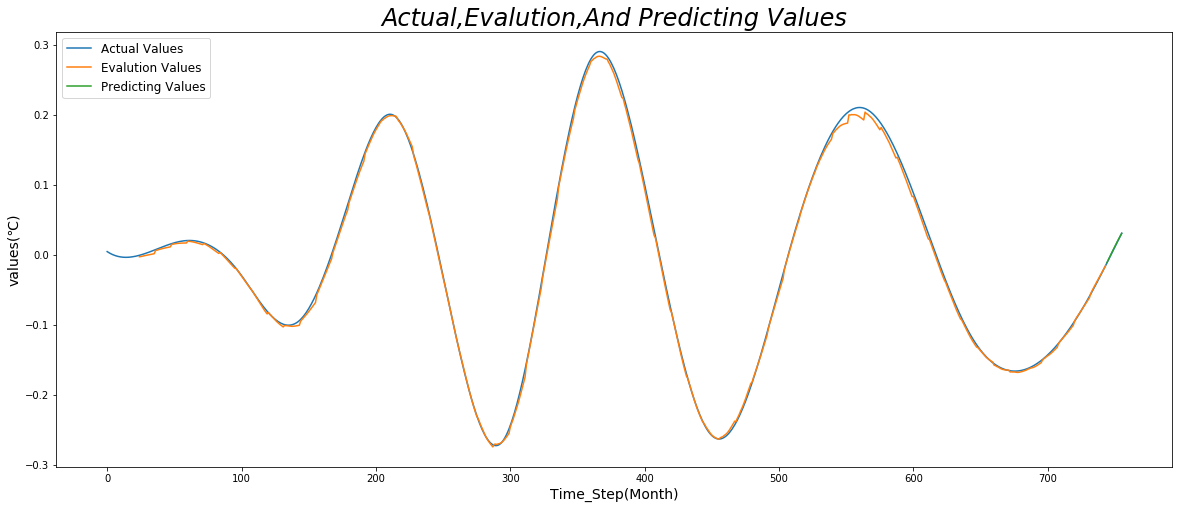

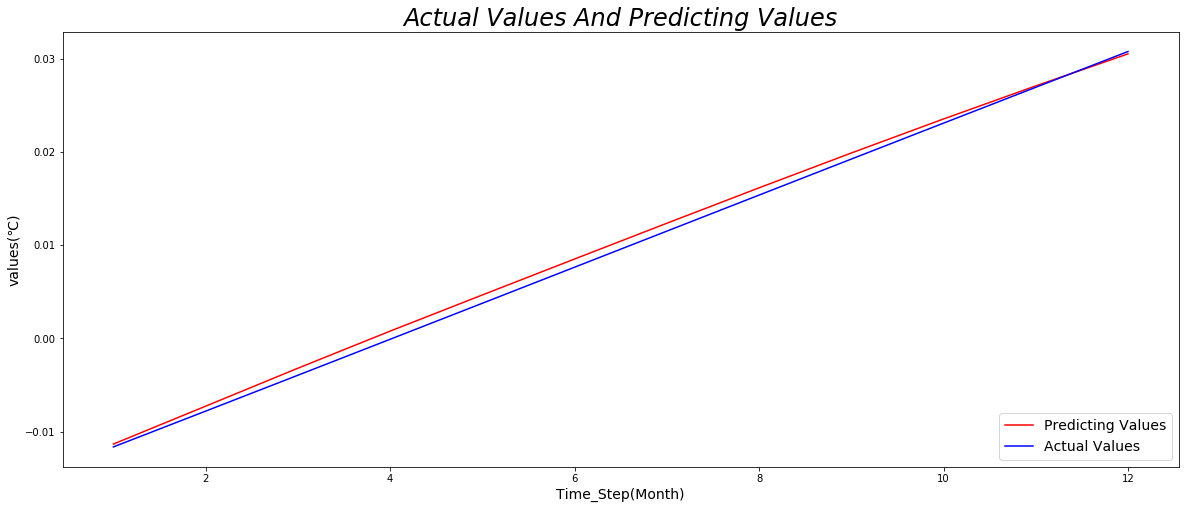

0     -0.12887
1     -0.12956
2     -0.13022
3     -0.13084
4     -0.13142
5     -0.13198
6     -0.13249
7     -0.13297
8     -0.13342
9     -0.13382
10    -0.13418
11    -0.13451
12    -0.13479
13    -0.13504
14    -0.13524
15    -0.13539
16    -0.13551
17    -0.13557
18    -0.13559
19    -0.13557
20    -0.13549
21    -0.13536
22    -0.13519
23    -0.13496
24    -0.13468
25    -0.13434
26    -0.13395
27    -0.13351
28    -0.13302
29    -0.13247
        ...   
726   -0.18868
727   -0.18755
728   -0.18641
729   -0.18525
730   -0.18408
731   -0.18290
732   -0.18171
733   -0.18050
734   -0.17928
735   -0.17806
736   -0.17682
737   -0.17557
738   -0.17432
739   -0.17305
740   -0.17178
741   -0.17049
742   -0.16920
743   -0.16791
744   -0.16660
745   -0.16529
746   -0.16397
747   -0.16264
748   -0.16131
749   -0.15998
750   -0.15864
751   -0.15729
752   -0.15594
753   -0.15459
754   -0.15323
755   -0.15187
Name: f6, Length: 756, dtype: float64
(756,)


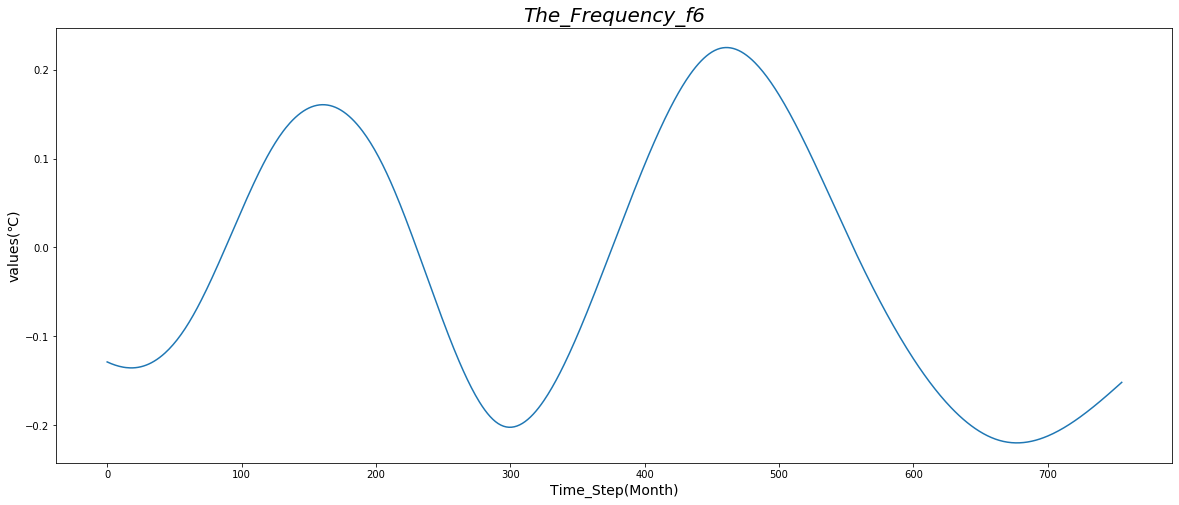

[[[-0.12887   ]
  [-0.12956   ]
  [-0.13022   ]
  [-0.13084   ]
  [-0.13142   ]
  [-0.13198   ]
  [-0.13249   ]
  [-0.13297   ]
  [-0.13342   ]
  [-0.13382   ]
  [-0.13418   ]
  [-0.13451   ]]

 [[-0.13479   ]
  [-0.13504   ]
  [-0.13524   ]
  [-0.13539   ]
  [-0.13551   ]
  [-0.13557   ]
  [-0.13559   ]
  [-0.13557   ]
  [-0.13549   ]
  [-0.13536   ]
  [-0.13519   ]
  [-0.13496   ]]

 [[-0.13468   ]
  [-0.13434   ]
  [-0.13395   ]
  [-0.13351   ]
  [-0.13302   ]
  [-0.13247   ]
  [-0.13187   ]
  [-0.13121   ]
  [-0.13049   ]
  [-0.12972   ]
  [-0.12889   ]
  [-0.12801   ]]

 [[-0.12707   ]
  [-0.12608   ]
  [-0.12502   ]
  [-0.12391   ]
  [-0.12274   ]
  [-0.12151   ]
  [-0.12022   ]
  [-0.11888   ]
  [-0.11747   ]
  [-0.116     ]
  [-0.11448   ]
  [-0.11289   ]]

 [[-0.11124   ]
  [-0.10953   ]
  [-0.10776   ]
  [-0.10593   ]
  [-0.10404   ]
  [-0.10208   ]
  [-0.10006   ]
  [-0.097974  ]
  [-0.095827  ]
  [-0.093616  ]
  [-0.091342  ]
  [-0.089005  ]]

 [[-0.086605  ]
  [-0.084145  

Epoch 1/200
 - 20s - loss: 0.0090
Epoch 2/200
 - 4s - loss: 0.0033
Epoch 3/200
 - 4s - loss: 0.0013
Epoch 4/200
 - 4s - loss: 4.4756e-04
Epoch 5/200
 - 4s - loss: 2.2508e-04
Epoch 6/200
 - 4s - loss: 8.3646e-05
Epoch 7/200
 - 4s - loss: 4.9129e-05
Epoch 8/200
 - 4s - loss: 7.8833e-05
Epoch 9/200
 - 3s - loss: 6.9363e-05
Epoch 10/200
 - 4s - loss: 6.0955e-05
Epoch 11/200
 - 4s - loss: 2.7179e-05
Epoch 12/200
 - 4s - loss: 2.4799e-05
Epoch 13/200
 - 4s - loss: 1.3168e-05
Epoch 14/200
 - 4s - loss: 1.6281e-05
Epoch 15/200
 - 4s - loss: 2.1644e-05
Epoch 16/200
 - 4s - loss: 5.9260e-05
Epoch 17/200
 - 3s - loss: 3.0821e-05
Epoch 18/200
 - 4s - loss: 2.9725e-05
Epoch 19/200
 - 4s - loss: 2.3762e-05
Epoch 20/200
 - 3s - loss: 1.1661e-05
Epoch 21/200
 - 4s - loss: 1.6957e-05
Epoch 22/200
 - 4s - loss: 2.6156e-05
Epoch 23/200
 - 3s - loss: 1.0649e-04
Epoch 24/200
 - 4s - loss: 6.2328e-05
Epoch 25/200
 - 3s - loss: 1.7121e-05
Epoch 26/200
 - 3s - loss: 1.9703e-05
Epoch 27/200
 - 4s - loss: 1.137

(60, 12)


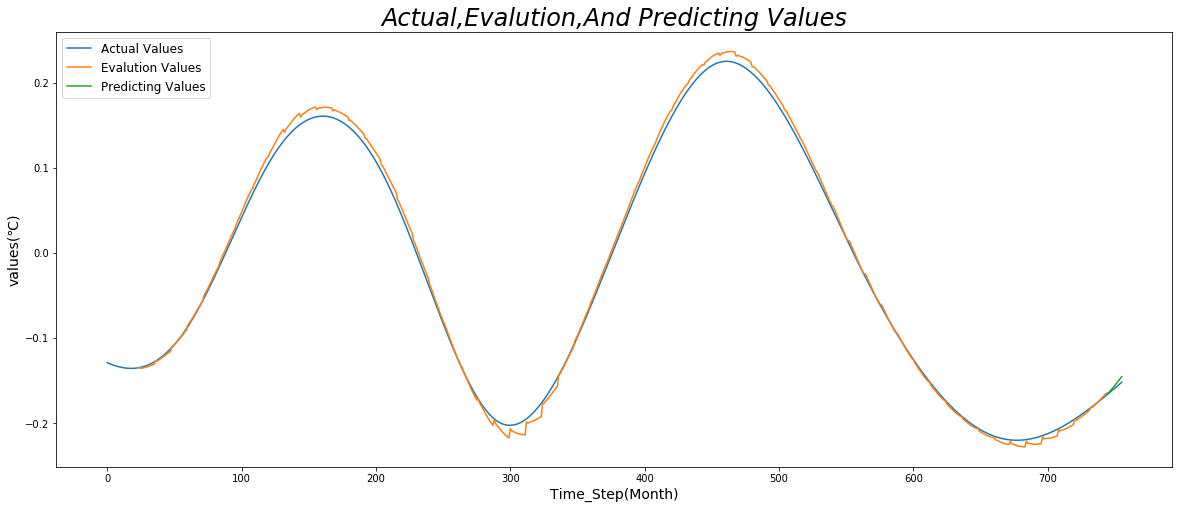

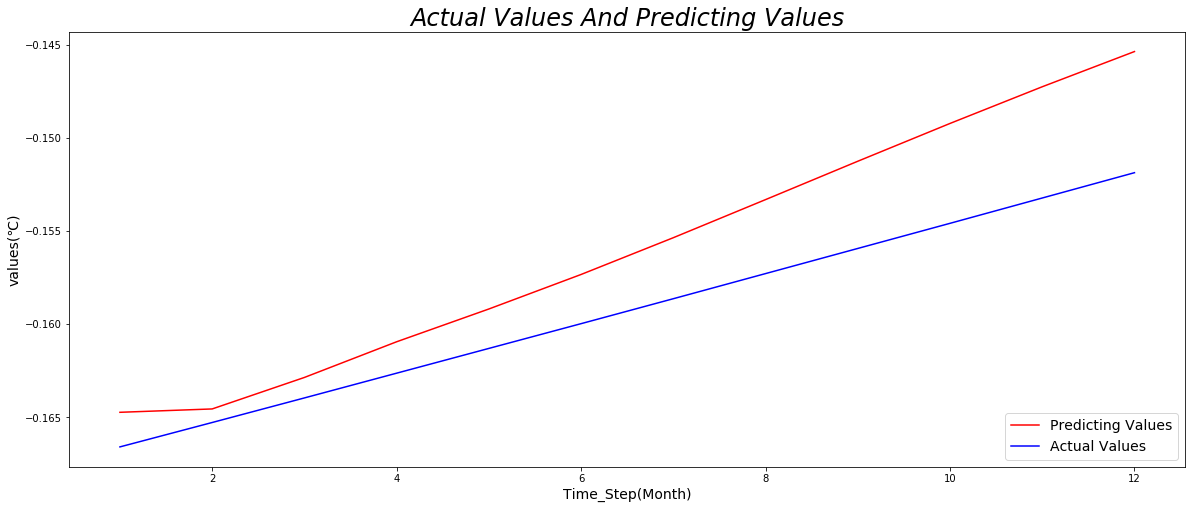

0      0.051841
1      0.051858
2      0.051870
3      0.051877
4      0.051878
5      0.051875
6      0.051866
7      0.051851
8      0.051832
9      0.051807
10     0.051776
11     0.051741
12     0.051700
13     0.051653
14     0.051601
15     0.051543
16     0.051480
17     0.051411
18     0.051337
19     0.051257
20     0.051172
21     0.051081
22     0.050984
23     0.050882
24     0.050774
25     0.050660
26     0.050542
27     0.050418
28     0.050288
29     0.050153
         ...   
726    0.043487
727    0.043420
728    0.043350
729    0.043278
730    0.043203
731    0.043125
732    0.043045
733    0.042962
734    0.042877
735    0.042790
736    0.042699
737    0.042607
738    0.042512
739    0.042414
740    0.042314
741    0.042211
742    0.042107
743    0.041999
744    0.041890
745    0.041778
746    0.041663
747    0.041546
748    0.041427
749    0.041306
750    0.041182
751    0.041056
752    0.040928
753    0.040797
754    0.040665
755    0.040530
Name: f7, Length: 756, d

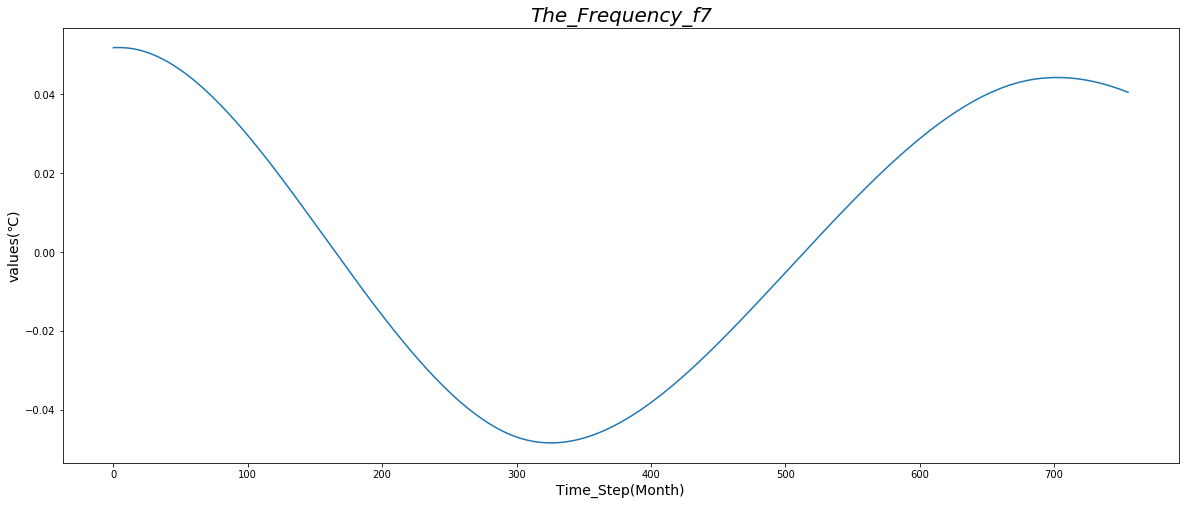

[[[ 5.1841e-02]
  [ 5.1858e-02]
  [ 5.1870e-02]
  [ 5.1877e-02]
  [ 5.1878e-02]
  [ 5.1875e-02]
  [ 5.1866e-02]
  [ 5.1851e-02]
  [ 5.1832e-02]
  [ 5.1807e-02]
  [ 5.1776e-02]
  [ 5.1741e-02]]

 [[ 5.1700e-02]
  [ 5.1653e-02]
  [ 5.1601e-02]
  [ 5.1543e-02]
  [ 5.1480e-02]
  [ 5.1411e-02]
  [ 5.1337e-02]
  [ 5.1257e-02]
  [ 5.1172e-02]
  [ 5.1081e-02]
  [ 5.0984e-02]
  [ 5.0882e-02]]

 [[ 5.0774e-02]
  [ 5.0660e-02]
  [ 5.0542e-02]
  [ 5.0418e-02]
  [ 5.0288e-02]
  [ 5.0153e-02]
  [ 5.0013e-02]
  [ 4.9868e-02]
  [ 4.9718e-02]
  [ 4.9562e-02]
  [ 4.9402e-02]
  [ 4.9236e-02]]

 [[ 4.9065e-02]
  [ 4.8889e-02]
  [ 4.8709e-02]
  [ 4.8523e-02]
  [ 4.8333e-02]
  [ 4.8138e-02]
  [ 4.7938e-02]
  [ 4.7733e-02]
  [ 4.7524e-02]
  [ 4.7310e-02]
  [ 4.7091e-02]
  [ 4.6868e-02]]

 [[ 4.6640e-02]
  [ 4.6408e-02]
  [ 4.6171e-02]
  [ 4.5930e-02]
  [ 4.5685e-02]
  [ 4.5435e-02]
  [ 4.5181e-02]
  [ 4.4923e-02]
  [ 4.4660e-02]
  [ 4.4394e-02]
  [ 4.4123e-02]
  [ 4.3848e-02]]

 [[ 4.3570e-02]
  [ 4.3287e-02

Epoch 1/200
 - 21s - loss: 8.7564e-04
Epoch 2/200
 - 3s - loss: 3.0626e-04
Epoch 3/200
 - 4s - loss: 1.3815e-04
Epoch 4/200
 - 4s - loss: 9.3952e-05
Epoch 5/200
 - 4s - loss: 7.2363e-05
Epoch 6/200
 - 4s - loss: 5.3476e-05
Epoch 7/200
 - 3s - loss: 4.4429e-05
Epoch 8/200
 - 3s - loss: 4.6527e-05
Epoch 9/200
 - 4s - loss: 4.1771e-05
Epoch 10/200
 - 4s - loss: 2.7053e-05
Epoch 11/200
 - 4s - loss: 2.6364e-05
Epoch 12/200
 - 4s - loss: 3.2861e-05
Epoch 13/200
 - 4s - loss: 2.6373e-05
Epoch 14/200
 - 4s - loss: 2.8504e-05
Epoch 15/200
 - 4s - loss: 2.2793e-05
Epoch 16/200
 - 4s - loss: 2.2373e-05
Epoch 17/200
 - 4s - loss: 3.0562e-05
Epoch 18/200
 - 4s - loss: 2.5046e-05
Epoch 19/200
 - 4s - loss: 1.6252e-05
Epoch 20/200
 - 4s - loss: 1.4046e-05
Epoch 21/200
 - 4s - loss: 9.5297e-06
Epoch 22/200
 - 4s - loss: 1.3634e-05
Epoch 23/200
 - 4s - loss: 9.8912e-06
Epoch 24/200
 - 4s - loss: 4.7098e-06
Epoch 25/200
 - 4s - loss: 1.4059e-06
Epoch 26/200
 - 4s - loss: 5.4131e-07
Epoch 27/200
 - 3s -

(60, 12)


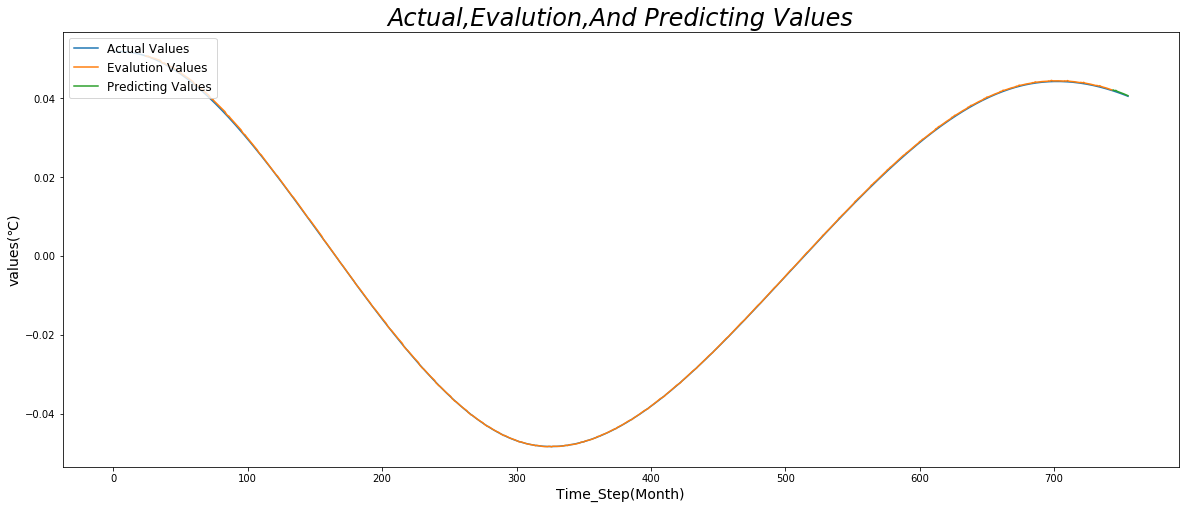

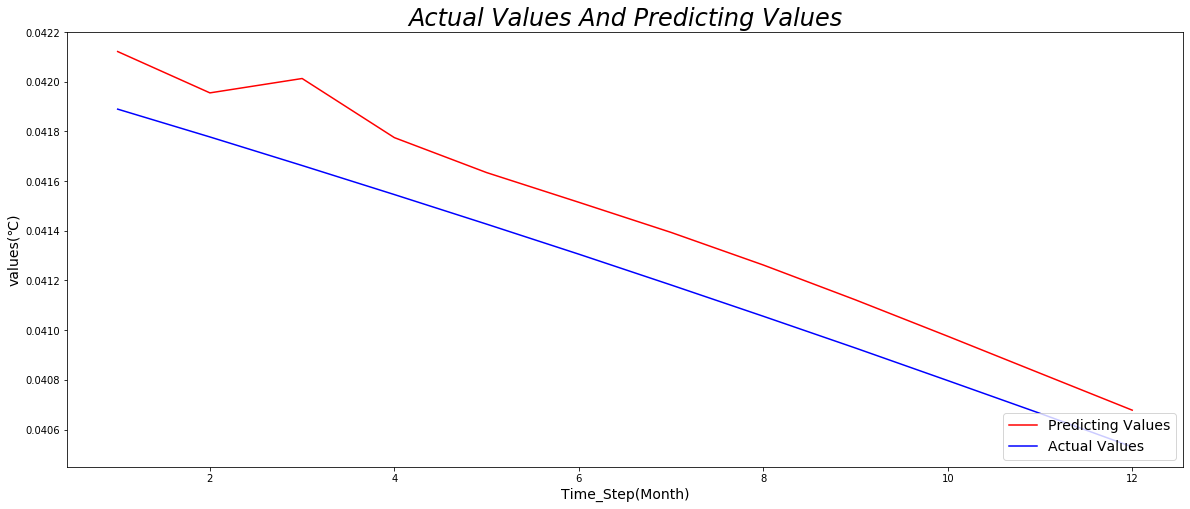

0      0.085791
1      0.085784
2      0.085777
3      0.085769
4      0.085762
5      0.085755
6      0.085747
7      0.085740
8      0.085733
9      0.085725
10     0.085718
11     0.085710
12     0.085703
13     0.085695
14     0.085687
15     0.085680
16     0.085672
17     0.085664
18     0.085657
19     0.085649
20     0.085641
21     0.085633
22     0.085625
23     0.085618
24     0.085610
25     0.085602
26     0.085594
27     0.085586
28     0.085578
29     0.085570
         ...   
726    0.078005
727    0.077998
728    0.077992
729    0.077985
730    0.077979
731    0.077973
732    0.077967
733    0.077961
734    0.077954
735    0.077948
736    0.077942
737    0.077936
738    0.077930
739    0.077924
740    0.077918
741    0.077912
742    0.077906
743    0.077900
744    0.077895
745    0.077889
746    0.077883
747    0.077877
748    0.077872
749    0.077866
750    0.077861
751    0.077855
752    0.077849
753    0.077844
754    0.077838
755    0.077833
Name: f8, Length: 756, d

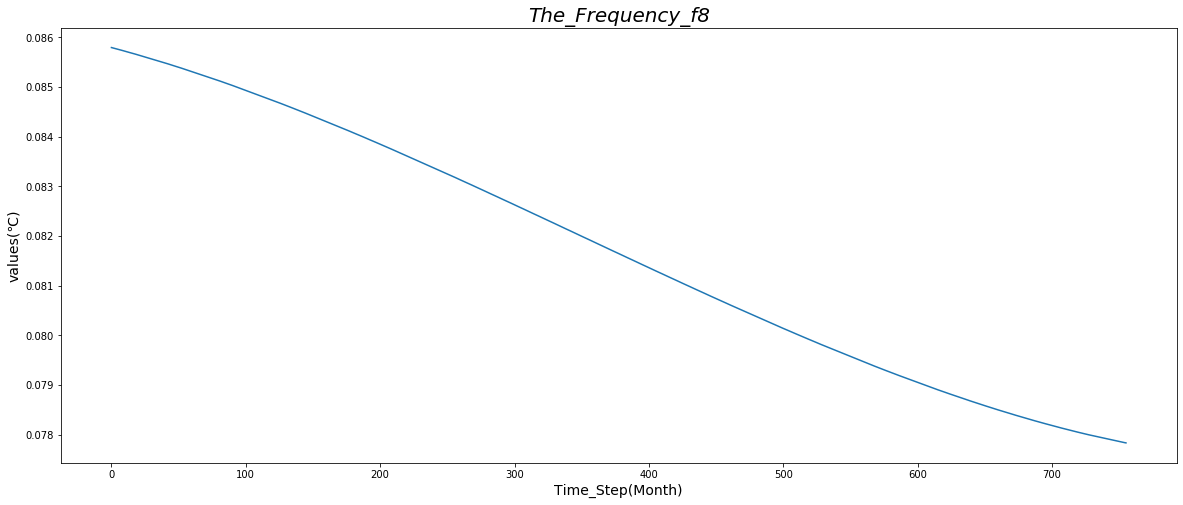

[[[0.085791]
  [0.085784]
  [0.085777]
  [0.085769]
  [0.085762]
  [0.085755]
  [0.085747]
  [0.08574 ]
  [0.085733]
  [0.085725]
  [0.085718]
  [0.08571 ]]

 [[0.085703]
  [0.085695]
  [0.085687]
  [0.08568 ]
  [0.085672]
  [0.085664]
  [0.085657]
  [0.085649]
  [0.085641]
  [0.085633]
  [0.085625]
  [0.085618]]

 [[0.08561 ]
  [0.085602]
  [0.085594]
  [0.085586]
  [0.085578]
  [0.08557 ]
  [0.085562]
  [0.085554]
  [0.085545]
  [0.085537]
  [0.085529]
  [0.085521]]

 [[0.085513]
  [0.085504]
  [0.085496]
  [0.085488]
  [0.085479]
  [0.085471]
  [0.085463]
  [0.085454]
  [0.085446]
  [0.085437]
  [0.085429]
  [0.08542 ]]

 [[0.085411]
  [0.085403]
  [0.085394]
  [0.085386]
  [0.085377]
  [0.085368]
  [0.085359]
  [0.085351]
  [0.085342]
  [0.085333]
  [0.085324]
  [0.085315]]

 [[0.085306]
  [0.085297]
  [0.085289]
  [0.08528 ]
  [0.085271]
  [0.085262]
  [0.085252]
  [0.085243]
  [0.085234]
  [0.085225]
  [0.085216]
  [0.085207]]

 [[0.085198]
  [0.085188]
  [0.085179]
  [0.08517 ]


Epoch 1/200
 - 22s - loss: 5.8460e-04
Epoch 2/200
 - 4s - loss: 1.3805e-05
Epoch 3/200
 - 4s - loss: 7.2997e-06
Epoch 4/200
 - 4s - loss: 6.3847e-06
Epoch 5/200
 - 3s - loss: 6.0859e-06
Epoch 6/200
 - 4s - loss: 5.9099e-06
Epoch 7/200
 - 4s - loss: 6.1710e-06
Epoch 8/200
 - 4s - loss: 6.0059e-06
Epoch 9/200
 - 4s - loss: 6.0731e-06
Epoch 10/200
 - 4s - loss: 5.7949e-06
Epoch 11/200
 - 3s - loss: 5.9722e-06
Epoch 12/200
 - 4s - loss: 6.0445e-06
Epoch 13/200
 - 4s - loss: 5.8644e-06
Epoch 14/200
 - 3s - loss: 5.6587e-06
Epoch 15/200
 - 4s - loss: 6.2094e-06
Epoch 16/200
 - 3s - loss: 6.0017e-06
Epoch 17/200
 - 4s - loss: 5.8103e-06
Epoch 18/200
 - 4s - loss: 6.0793e-06
Epoch 19/200
 - 4s - loss: 6.7570e-06
Epoch 20/200
 - 4s - loss: 6.7607e-06
Epoch 21/200
 - 4s - loss: 5.7037e-06
Epoch 22/200
 - 4s - loss: 5.9278e-06
Epoch 23/200
 - 4s - loss: 6.8971e-06
Epoch 24/200
 - 4s - loss: 8.2413e-06
Epoch 25/200
 - 4s - loss: 6.3222e-06
Epoch 26/200
 - 4s - loss: 5.5923e-06
Epoch 27/200
 - 4s -

(60, 12)


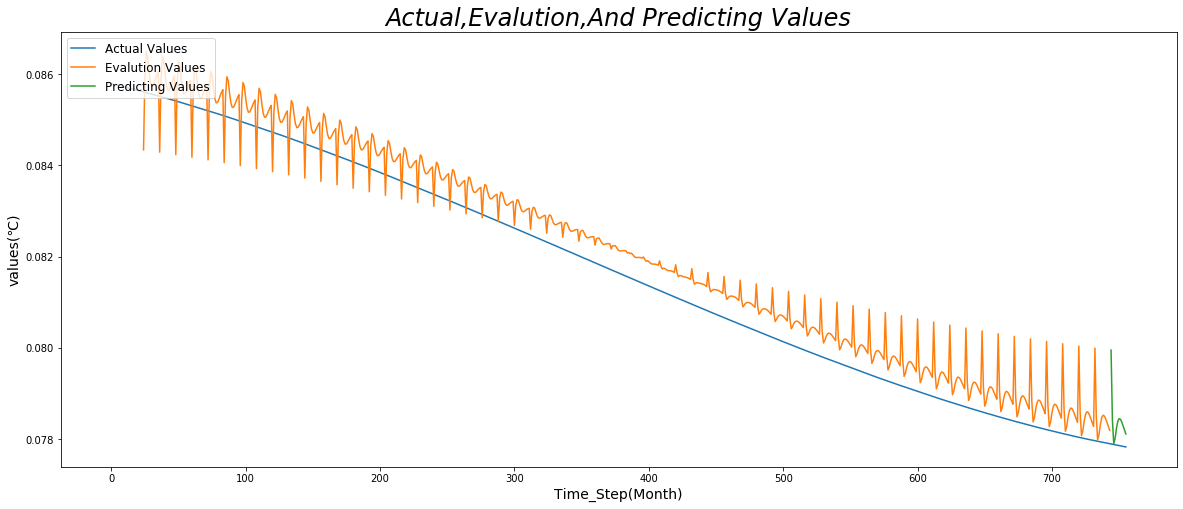

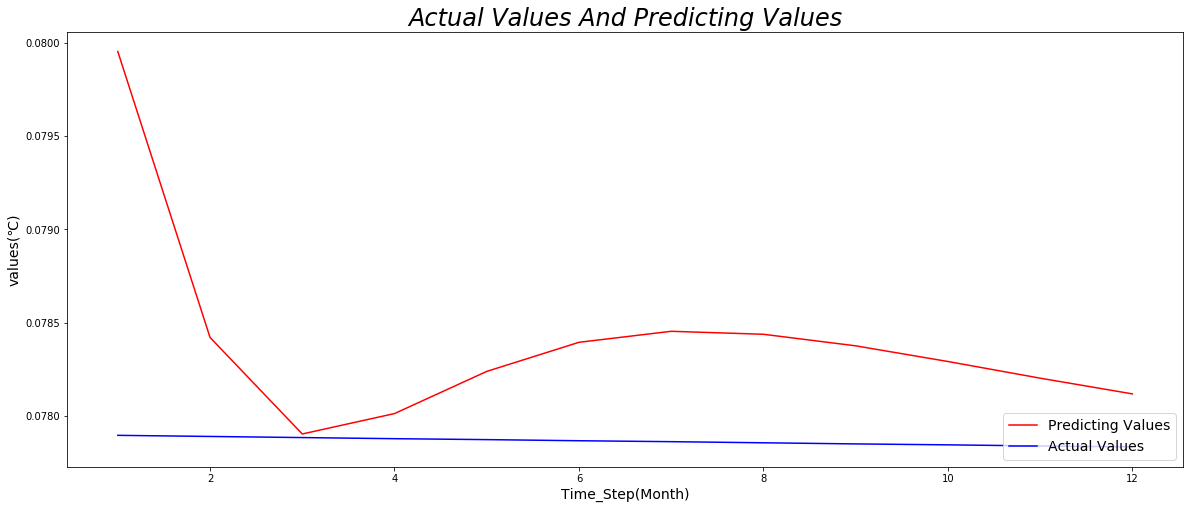

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-72]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07995331]
 [0.07842006]
 [0.07790221]
 [0.0780117 ]
 [0.07823783]
 [0.07839392]
 [0.07845296]
 [0.07843702]
 [0.07837505]
 [0.07829102]
 [0.07820167]
 [0.07811734]]
[array([ 0.02567  ,  0.13162  ,  0.071521 , -0.037868 , -0.069171 ,
        0.015659 ,  0.046654 , -0.041721 , -0.0042809,  0.038246 ,
        0.042989 ,  0.042706 ]), array([-0.33623 , -0.37484 , -0.33777 , -0.23725 , -0.096246,  0.051585,
        0.18061 ,  0.26078 ,  0.24883 ,  0.15758 ,  0.019498, -0.10856 ]), array([-0.11916 , -0.033139,  0.045401,  0.1132  ,  0.16712 ,  0.20401 ,
        0.22072 ,  0.21408 ,  0.18292 ,  0.13441 ,  0.077831,  0.022456]), array([0.092297, 0.12559 , 0.15537 , 0.18036 , 0.19929 , 0.21089 ,
       0.21389 , 0.20705 , 0.18968 , 0.1626  , 0.12704 , 0.084259]), array([-0.40412, -0.39579, -0.38613, -0.37512, -0.36273, -0.34896,
       -0.33377, -0.31716, -0.2992 , -0.27995, -0.25955, -0.2381 ]), array([-0.011649  , -0.007813  , -0.0039651 , -0.00010857,  0.0037541 ,
        0.0076204 ,  0.

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[ 0.02567    0.13162    0.071521  -0.037868  -0.069171   0.015659
  0.046654  -0.041721  -0.0042809  0.038246   0.042989   0.042706 ]
[[ 0.02567  ]
 [ 0.13162  ]
 [ 0.071521 ]
 [-0.037868 ]
 [-0.069171 ]
 [ 0.015659 ]
 [ 0.046654 ]
 [-0.041721 ]
 [-0.0042809]
 [ 0.038246 ]
 [ 0.042989 ]
 [ 0.042706 ]]
[[ 0.03]
 [ 0.13]
 [ 0.07]
 [-0.04]
 [-0.07]
 [ 0.02]
 [ 0.05]
 [-0.04]
 [-0.  ]
 [ 0.04]
 [ 0.04]
 [ 0.04]]
-----------------------------------
observe value:[-0.33623  -0.37484  -0.33777  -0.23725  -0.096246  0.051585  0.18061
  0.26078   0.24883   0.15758   0.019498 -0.10856 ]
[[-0.31056  ]
 [-0.24322  ]
 [-0.266249 ]
 [-0.275118 ]
 [-0.165417 ]
 [ 0.067244 ]
 [ 0.227264 ]
 [ 0.219059 ]
 [ 0.2445491]
 [ 0.195826 ]
 [ 0.062487 ]
 [-0.065854 ]]
[[-0.31]
 [-0.24]
 [-0.27]
 [-0.28]
 [-0.17]
 [ 0.07]
 [ 0.23]
 [ 0.22]
 [ 0.24]
 [ 0.2 ]
 [ 0.06]
 [-0.07]]
-----------------------------------
observe value:[-0.11916  -0.033139  0.045401  0.1132    0.16712   0.20401   0.22072
  0.

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[ 0.01661729 -0.01816332 -0.11278556 -0.16292806 -0.14889176 -0.10985865
 -0.08335589 -0.07304569 -0.06454733 -0.0507993  -0.03819416 -0.03438815]
[ 0.01661729 -0.01816332 -0.11278556 -0.16292806 -0.14889176 -0.10985865
 -0.08335589 -0.07304569 -0.06454733 -0.0507993  -0.03819416 -0.03438815]
the 1 frequence:
predicted_value:[-0.3603778  -0.3709824  -0.31561133 -0.22184345 -0.11230807  0.00585079
  0.12005944  0.21203522  0.26309603  0.26075014  0.20446     0.10736296]
[-0.3437605  -0.38914573 -0.4283969  -0.38477151 -0.26119983 -0.10400786
  0.03670355  0.13898953  0.1985487   0.20995084  0.16626584  0.0729748 ]
the 2 frequence:
predicted_value:[-0.10447912 -0.02626315  0.05137908  0.10620799  0.13796474  0.15024178
  0.15249251  0.15211713  0.15376513  0.15987013  0.17118888  0.18722855]
[-0.44823962 -0.41540887 -0.37701782 -0.27856352 -0.12323509  0.04623392
  0.18919606  0.29110666  0.35231383  0.36982097  0.337

[[-0.8]
 [-0.6]
 [-0.5]
 [-0.4]
 [-0.2]
 [ 0.1]
 [ 0.3]
 [ 0.3]
 [ 0.3]
 [ 0.2]
 [-0. ]
 [-0.2]]
[-0.81865262 -0.74970965 -0.6766997  -0.54229593 -0.35601942 -0.15900659
  0.00811796  0.12994266  0.20618861  0.23416366  0.20915701  0.13852284]


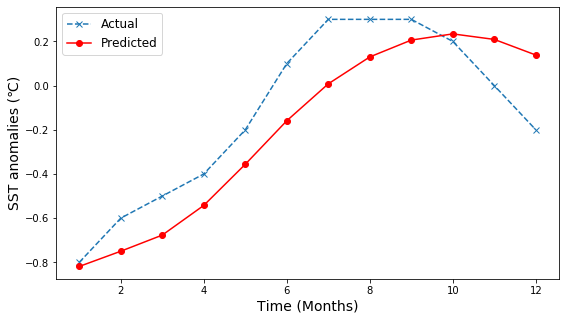

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
